#Training a Smart AutoEncoder
Let us train a "smart" AutoEncoder over MNIST. In addition to the standard reconstruction loss, this AE is also trained to predict the correct label of the input from the latent code. The idea is that this additional loss term might aid in the task of anomaly detection, as the latent space will be highly ordered. 

Anyway, this is not the focus of this notebook. We will start by training the model without using any wandb functionality and later see how incorporating wandb might improve the interpretability and reproducability of the results.

In [ ]:
# importing the necessary packages
!pip install -U torchvision
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from torchvision import datasets, transforms
from torchvision.utils import make_grid 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from PIL import Image
import pickle
import os

# It's colab so we have a GPU if we set it up in "runtime"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.0+cu101)


In [ ]:
# Hyperparameters
batch_size = 128
epochs = 5
hidden_size = 32

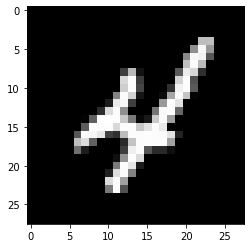

In [ ]:
# Used to fix an internet problem, can be ignored. Still, sometimes the cell
# gives an 503HTTP error. If that happens just rerun this cell (over and over)
from six.moves import urllib 
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# defining a transfrom that will convert MNIST to tensor
random_flips = transforms.Compose([
         transforms.ToTensor()                             
])

# defining datasets and dataloaders
mnist_train = datasets.MNIST('data', train=True, download=True, transform=random_flips)
mnist_val = datasets.MNIST('data', train=False, download=True, transform=random_flips)


train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=mnist_val, batch_size=batch_size, shuffle=False)

plt.imshow(mnist_train[9][0][0].numpy(), cmap="gray")

In [ ]:
 def plot_tsne(model, batches=10):
    """
    Visualization of the separation quality of the model, to see how
    ordered the latent space is.
    """
    codes = None
    y = None
    i = 0
    for data in test_loader:
      X, targets = data
      X = X.to(device)

      batch_codes = model.encode(X).detach().to("cpu")
      if codes is None:
        codes = np.asarray(batch_codes)
        y = targets
      else:
        codes = np.concatenate([codes, batch_codes], 0)
        y = np.concatenate([y, targets], 0)
      i +=1
      if i == batches:
        break

    codes_pca = TSNE(n_components=2).fit_transform(codes)
    fig, ax = plt.subplots()
    for i in range(10):
      locs = y == i
      ax.scatter(codes_pca[locs, 0], codes_pca[locs, 1], label=str(i))
    return ax


def reconstruct_sample(model, n: int = 10):
  """
  Reconstruction of a sample of images using the model
  """
  X, _ = next(test_loader.__iter__())
  X = X[:n].to(device)
  recons, _ = model(X)
  im = torch.cat([X, recons], 2)
  im = im.detach().to("cpu").numpy()
  im = np.concatenate(im, 2)
  return im



In [ ]:
class SmartAutoEncoder(nn.Module):
  """
  Smart AE network, which uses a prediction task as a regularization
  """
  def __init__(self, hidden_size=2, n_classes=10):
    super(SmartAutoEncoder, self).__init__()

    self.hidden_size = hidden_size
    self.encoder = nn.Sequential(
          nn.Conv2d(1, 16, 3, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(16, 32, 3, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(32, hidden_size, 7),  # out shape: [bs, hidden_size, 1, 1]
          nn.Flatten(), # out shape: [bs, hidden_size]
      )
    self.decoder = nn.Sequential(
          nn.ConvTranspose2d(hidden_size, 32, 7),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
          nn.Sigmoid()
      )
    self.classification_head = nn.Linear(hidden_size, n_classes)
    
  def encode(self, x):
    code = self.encoder(x)
    return code

  def decode(self, code):
    code = code.view((-1, self.hidden_size, 1, 1))
    return self.decoder(code)

  def forward(self, x):
    code = self.encode(x)
    reconstructed = self.decode(code)
    prediction = self.classification_head(code)
    return reconstructed, prediction


class SmartAELoss(nn.Module):
  """
  A class to calculate the losses and accuracy metrics of the AE
  """
  def __init__(self, classification_weight: float = 0.5):
    super(SmartAELoss, self).__init__()
    self.cls_weight = classification_weight
    self.recon_criterion = nn.L1Loss()
    self.prediction_criterion = nn.CrossEntropyLoss()

  def forward(self, recon_x, x, pred_y, y):
    recon_loss = self.recon_criterion(recon_x, x,)
    pred_loss = self.prediction_criterion(pred_y, y)
    total_loss = (1 - self.cls_weight) * recon_loss + self.cls_weight * pred_loss

    # to calc the accuracy
    pred_class = pred_y.data.max(1, keepdim=True)[1]
    correct = pred_class.eq(y.data.view_as(pred_class)).sum()
    accuracy = 100. * correct / batch_size

    metrics = {"recon_loss": float(recon_loss.detach()),
               "pred_loss": float(pred_loss.detach()),
               "pred_acc": float(accuracy.detach()),
               "total_loss": float(total_loss.detach())}
    return total_loss, metrics


In [ ]:

def validate(epoch: int, model: nn.Module, val_dl: DataLoader, crit: nn.Module):
  """
  The validation step
  """
  model.eval()
  metrics = {"recon_loss": [],
              "pred_loss": [],
              "pred_acc": [],
              "total_loss": []
             }

  for data in val_dl:
    img, target = data
    img, target = img.to(device), target.to(device)
    recon_img, pred = model(img)
    _, batch_metrics = crit(recon_img, img, pred, target)
    for key in metrics.keys():
      metrics[key].append(batch_metrics[key])

  # calc the mean of the metrics over entire val set
  for key in metrics.keys():
      metrics[key] = np.mean(metrics[key])
  return metrics


def train(epoch: int, model: nn.Module, train_dl: DataLoader, crit: nn.Module, optim: torch.optim.Optimizer):
  """
  The training step
  """
  model.train()
  metrics = {"recon_loss": [],
              "pred_loss": [],
              "pred_acc": [],
              "total_loss": []
             }
  for data in train_dl:
    img, target = data
    img, target = img.to(device), target.to(device)
    recon_img, pred = model(img)
    loss, batch_metrics = crit(recon_img, img, pred, target)
    loss.backward()
    optim.step()
    optim.zero_grad()
    for key in metrics.keys():
      metrics[key].append(batch_metrics[key])

  for key in metrics.keys():
    metrics[key] = np.mean(metrics[key])
  return metrics    

def fit_model(model, num_epochs=5, learning_rate=1e-3, pred_loss_weight=1):
    
    torch.manual_seed(42)
    criterion = SmartAELoss(pred_loss_weight).to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    
    for epoch in range(num_epochs):
        train_metrics = train(epoch, model, train_loader, criterion, optimizer)
        val_metrics = validate(epoch, model, test_loader, criterion)

        print('Epoch:{}, Train Loss:{:.4f}, Train Accuracy:{:.4f}'.format(epoch+1, train_metrics["total_loss"], train_metrics["pred_acc"]), end=" ")
        print('Epoch:{}, Val Loss:{:.4f}, Val Accuracy:{:.4f}'.format(epoch+1, val_metrics["total_loss"], val_metrics["pred_acc"]))
    return model

In [ ]:
# let us define and train the model
model = SmartAutoEncoder(hidden_size).to(device)
model = fit_model(model, epochs, pred_loss_weight=0.5)

Epoch:1, Train Loss:0.7178, Train Accuracy:51.0261 Epoch:1, Val Loss:0.4737, Val Accuracy:66.1195
Epoch:2, Train Loss:0.4172, Train Accuracy:76.7641 Epoch:2, Val Loss:0.3527, Val Accuracy:82.3081
Epoch:3, Train Loss:0.3469, Train Accuracy:83.3339 Epoch:3, Val Loss:0.3181, Val Accuracy:83.8904
Epoch:4, Train Loss:0.3148, Train Accuracy:85.3778 Epoch:4, Val Loss:0.2919, Val Accuracy:85.5914
Epoch:5, Train Loss:0.2947, Train Accuracy:86.4755 Epoch:5, Val Loss:0.2745, Val Accuracy:87.0550


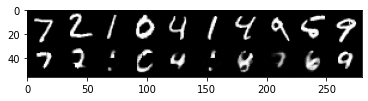

In [ ]:
# visualization of the results
res = reconstruct_sample(model)
plt.imshow(res[0], cmap="gray")

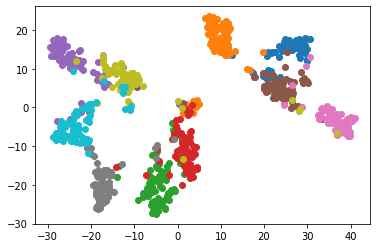

In [ ]:
ax = plot_tsne(model, batches=5)
plt.show()

# Basic logging with wandb
The code above works beautifully, but it is far from being easily reproducible, and there are bearly any insights into the training process of the model. We can fix that by using wandb!


We will talk about:

*   What is wandb
*   wandb web interface
*   Projects
*   Runs
*   Configs
*   Logging metrics
*   Analyzing a run 
*   Reproducability



In [ ]:
!pip install wandb
import wandb


In [ ]:
wandb.init(project="SmartAE",  # mandatory
           tags=["metrics"],  # optional, for easy navigation and such
           job_type="training_demo", # optional, but recommended. for grouping *runs*.
           name="simple_logging_example",  # optional, but recommended. The name of the run (random name if None)
           save_code=True,
           config={
    "learning_rate": 1e-3,
    "batch_size": 128,
    "epochs": 5,
    "hidden_size": 32,
    "pred_loss_weight": 0.5,
    "seed": 42
})
config = wandb.config

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
def validate(epoch: int, model: nn.Module, val_dl: DataLoader, crit: nn.Module):
  model.eval()
  metrics = {"recon_loss": [],
              "pred_loss": [],
              "pred_acc": [],
              "total_loss": []
             }

  for data in val_dl:
    img, target = data
    img, target = img.to(device), target.to(device)
    recon_img, pred = model(img)
    _, batch_metrics = crit(recon_img, img, pred, target)
    for key in metrics.keys():
      metrics[key].append(batch_metrics[key])

  for key in metrics.keys():
    metrics[key] = np.mean(metrics[key])

  # This is new - logging metrics (with a dict).
  wandb.log({"val_accuracy": metrics["pred_acc"],
             "val_recon_loss": metrics["recon_loss"],
             "val_prediction_loss": metrics["pred_loss"],
             "val_total_loss": metrics["total_loss"]})
  
  return metrics


def train(epoch: int, model: nn.Module, train_dl: DataLoader, crit: nn.Module, optim: torch.optim.Optimizer):
  model.train()
  metrics = {"recon_loss": [],
              "pred_loss": [],
              "pred_acc": [],
              "total_loss": []
             }
  for i, data in enumerate(train_dl):
    img, target = data
    img, target = img.to(device), target.to(device)
    recon_img, pred = model(img)
    loss, batch_metrics = crit(recon_img, img, pred, target)
    loss.backward()
    optim.step()
    optim.zero_grad()

    # This is also new. We can be split into several logging steps,
    # but then need to use the "commit=False" flag in all but the last step,
    # otherwise wandb won't be able to tell that we logged
    # both dicts in the same batch
    wandb.log(batch_metrics, commit=False)
    wandb.log({"epoch": epoch})

    for key in metrics.keys():
      metrics[key].append(batch_metrics[key])

  for key in metrics.keys():
    metrics[key] = np.mean(metrics[key])
  
  return metrics    

def fit_model(model, num_epochs=5, learning_rate=1e-3, pred_loss_weight=1):
    criterion = SmartAELoss(pred_loss_weight).to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    
    for epoch in range(num_epochs):
        train_metrics = train(epoch, model, train_loader, criterion, optimizer)
        val_metrics = validate(epoch, model, test_loader, criterion)

        print('Epoch:{}, Train Loss:{:.4f}, Train Accuracy:{:.4f}'.format(epoch+1, train_metrics["total_loss"], train_metrics["pred_acc"]), end=" ")
        print('Epoch:{}, Val Loss:{:.4f}, Val Accuracy:{:.4f}'.format(epoch+1, val_metrics["total_loss"], val_metrics["pred_acc"]))
    return model




In [ ]:
torch.manual_seed(config.seed)
model = SmartAutoEncoder(config.hidden_size).to(device)
model = fit_model(model, config.epochs, pred_loss_weight=config.pred_loss_weight, learning_rate=config.learning_rate)

Epoch:1, Train Loss:0.2778, Train Accuracy:86.9453 Epoch:1, Val Loss:0.1283, Val Accuracy:93.3445
Epoch:2, Train Loss:0.1037, Train Accuracy:95.5840 Epoch:2, Val Loss:0.0746, Val Accuracy:95.7377
Epoch:3, Train Loss:0.0704, Train Accuracy:97.0482 Epoch:3, Val Loss:0.0580, Val Accuracy:96.4399
Epoch:4, Train Loss:0.0575, Train Accuracy:97.6279 Epoch:4, Val Loss:0.0500, Val Accuracy:96.8354
Epoch:5, Train Loss:0.0497, Train Accuracy:97.9861 Epoch:5, Val Loss:0.0453, Val Accuracy:97.0332


#Logging **images**, **files** and **histograms**!

We will see how simple it is to log any imaginable datatype to wandb.
We will also see how to log the model and model stats/parameters/grads, and how to load them.

In [ ]:
wandb.init(project="SmartAE",  # Same as before
           tags=["metrics", "images", "files", "histograms"], 
           job_type="training_demo",
           name="advanced_logging_example",
           save_code=True,
           config={
    "learning_rate": 1e-3,
    "batch_size": 128,
    "epochs": 5,
    "hidden_size": 32,
    "pred_loss_weight": 0.5,
    "seed": 42
})
config = wandb.config


recon_loss,0.07363
pred_loss,0.09582
pred_acc,73.4375
total_loss,0.08473
epoch,1
_runtime,15
_timestamp,1615896285
_step,939
val_accuracy,95.10483
val_recon_loss,0.07134
val_prediction_loss,0.12939


recon_loss,██▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pred_loss,█▇▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pred_acc,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇█████▇██
total_loss,█▇▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁█
val_recon_loss,█▁
val_prediction_loss,█▁


In [ ]:
def validate(epoch: int, model: nn.Module, val_dl: DataLoader, crit: nn.Module):
  model.eval()
  metrics = {"recon_loss": [],
              "pred_loss": [],
              "pred_acc": [],
              "total_loss": []
             }

  for data in val_dl:
    img, target = data
    img, target = img.to(device), target.to(device)
    recon_img, pred = model(img)
    _, batch_metrics = crit(recon_img, img, pred, target)
    for key in metrics.keys():
      metrics[key].append(batch_metrics[key])

  for key in metrics.keys():
    metrics[key] = np.mean(metrics[key])

  wandb.log({"val_accuracy": metrics["pred_acc"],
             "val_recon_loss": metrics["recon_loss"],
             "val_prediction_loss": metrics["pred_loss"],
             "val_total_loss": metrics["total_loss"]})
  
  # logging images
  sample_image: np.ndarray = reconstruct_sample(model)
  wandb.log({"reconstructed_sample": wandb.Image(sample_image)})
  
  return metrics


def train(epoch: int, model: nn.Module, train_dl: DataLoader, crit: nn.Module, optim: torch.optim.Optimizer):
  model.train()
  metrics = {"recon_loss": [],
              "pred_loss": [],
              "pred_acc": [],
              "total_loss": []
             }
  for i, data in enumerate(train_dl):
    img, target = data
    img, target = img.to(device), target.to(device)
    recon_img, pred = model(img)
    loss, batch_metrics = crit(recon_img, img, pred, target)
    loss.backward()
    optim.step()
    optim.zero_grad()

    wandb.log(batch_metrics, commit=False)
    wandb.log({"epoch": epoch})

    for key in metrics.keys():
      metrics[key].append(batch_metrics[key])

  for key in metrics.keys():
    metrics[key] = np.mean(metrics[key])
  

  return metrics    

def fit_model(model, num_epochs=5, learning_rate=1e-3, pred_loss_weight=1):
    
    criterion = SmartAELoss(pred_loss_weight).to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    
    # a single line to log all the model's statistics!
    wandb.watch(model, criterion, log="all", log_freq=10) 

    for epoch in range(num_epochs):
        train_metrics = train(epoch, model, train_loader, criterion, optimizer)
        val_metrics = validate(epoch, model, test_loader, criterion)

        print('Epoch:{}, Train Loss:{:.4f}, Train Accuracy:{:.4f}'.format(epoch+1, train_metrics["total_loss"], train_metrics["pred_acc"]), end=" ")
        print('Epoch:{}, Val Loss:{:.4f}, Val Accuracy:{:.4f}'.format(epoch+1, val_metrics["total_loss"], val_metrics["pred_acc"]))
    
    # We can also log matplotlib figures!
    scatter_plot = plot_tsne(model)
    wandb.log({"tsne_plot": scatter_plot}) 

    return model


In [ ]:
torch.manual_seed(config.seed)
model = SmartAutoEncoder(config.hidden_size).to(device)
model = fit_model(model, config.epochs, pred_loss_weight=config.pred_loss_weight, learning_rate=config.learning_rate)





Epoch:1, Train Loss:0.2778, Train Accuracy:86.9486 Epoch:1, Val Loss:0.1283, Val Accuracy:93.3643
Epoch:2, Train Loss:0.1037, Train Accuracy:95.5824 Epoch:2, Val Loss:0.0744, Val Accuracy:95.7377
Epoch:3, Train Loss:0.0703, Train Accuracy:97.0532 Epoch:3, Val Loss:0.0579, Val Accuracy:96.4498
Epoch:4, Train Loss:0.0574, Train Accuracy:97.6379 Epoch:4, Val Loss:0.0499, Val Accuracy:96.8354
Epoch:5, Train Loss:0.0497, Train Accuracy:97.9678 Epoch:5, Val Loss:0.0451, Val Accuracy:97.0431


In [ ]:
# It is also possible to log general files
save_path = "model.pt"
torch.save(model.state_dict(), save_path)  # here we are saving the model's state dict localy
wandb.save(save_path)  # here we are saving the model's state dict on the server

['/content/wandb/run-20210316_115322-vbewitq0/files/model.pt']

# Lets log more than one run

We will talk about:

1.   Comparing runs using the project window
2.   Using the table view
3.   Filtering and grouping




In [ ]:
wandb.init(project="SmartAE",  # Same as before
           tags=["metrics", "images", "files", "histograms", "hs8"], 
           job_type="training_demo",
           name="multi_run3",
           save_code=True,
           config={
    "learning_rate": 1e-3,
    "batch_size": 128,
    "epochs": 2,
    "hidden_size": 8,
    "pred_loss_weight": 0.5,
    "seed": 42
})
config = wandb.config

torch.manual_seed(config.seed)
model = SmartAutoEncoder(config.hidden_size).to(device)
model = fit_model(model, config.epochs, pred_loss_weight=config.pred_loss_weight, learning_rate=config.learning_rate)

save_path = "model.pt"
torch.save(model.state_dict(), save_path)
wandb.save(save_path)


In [ ]:
wandb.init(project="SmartAE",  # Same as before
           tags=["metrics", "images", "files", "histograms", "hs8"], 
           job_type="training_demo",
           name="multi_run2",
           save_code=True,
           config={
    "learning_rate": 1e-3,
    "batch_size": 128,
    "epochs": 2,
    "hidden_size": 32,
    "pred_loss_weight": 0.1,
    "seed": 42
})

torch.manual_seed(config.seed)
model = SmartAutoEncoder(config.hidden_size).to(device)
model = fit_model(model, config.epochs, pred_loss_weight=config.pred_loss_weight, learning_rate=config.learning_rate)

save_path = "model.pt"
torch.save(model.state_dict(), save_path)
wandb.save(save_path)

# Sweeps

We will talk about sweeps - how to use them and how to analyze the results

We will also learn how to run sweeps from multiple machines, and how to stop a sweep from the interface

In [ ]:
sweep_config = {
  "name": "SmartAE Sweep",  # the name of the sweep - mandatory
  "method": "random",  # hyperparameter search type [grid, random, bayes]
  'metric': {  # which metric to evaluate
      'name': 'val_recon_loss',
      'goal': 'minimize'   
    }, 
  "parameters": {  # defining the parameters of the hyperparameter search.
                   # This is good for random search, other search methods will look differently
        "hidden_size": {
            "values": [2, 4, 8, 16, 32, 64, 128]
        },
        "pred_loss_weight": {
            "values": [0.0, 0.05, 0.2, 0.5, 0.8, 0.95, 1.0]
        },
        "epochs": {
            "values": [2]
        },
        "learning_rate": {
            "values": [1e-1, 1e-3, 1e-5]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project="SmartAE")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: rpn1tygf
Sweep URL: https://wandb.ai/nadav_bor/SmartAE/sweeps/rpn1tygf


In [ ]:
# a utility function, needed if running from notebooks
def main():
  run = wandb.init()
  run.config.seed = 42
  config = run.config
  print("config:", dict(config))

  torch.manual_seed(config.seed)
  model = SmartAutoEncoder(config.hidden_size).to(device)
  model = fit_model(model, config.epochs, pred_loss_weight=config.pred_loss_weight, learning_rate=config.learning_rate)

wandb.agent(sweep_id, function=main, count=5)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: wqa13t0v with config:
wandb: 	epochs: 2
wandb: 	hidden_size: 2
wandb: 	learning_rate: 1e-05
wandb: 	pred_loss_weight: 0.05


config: {'epochs': 2, 'hidden_size': 2, 'learning_rate': 1e-05, 'pred_loss_weight': 0.05, 'seed': 42}


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



Epoch:1, Train Loss:0.6013, Train Accuracy:9.8731 Epoch:1, Val Loss:0.5989, Val Accuracy:9.4739
Epoch:2, Train Loss:0.5965, Train Accuracy:9.9380 Epoch:2, Val Loss:0.5932, Val Accuracy:10.3639


recon_loss,0.50377
pred_loss,2.28519
pred_acc,10.9375
total_loss,0.59284
epoch,1
_runtime,30
_timestamp,1615843853
_step,942
val_accuracy,10.36392
val_recon_loss,0.50407
val_prediction_loss,2.28734


recon_loss,█▆█▇▇▇▇▇▇▇▆▆▆▆▆▅▆▅▄▄▆▄▅▃▄▃▄▃▄▅▄▃▁▂▃▂▁▁▂▁
pred_loss,▅▅█▅▆▄█▇▃▄▃▇▆▄▅▅▆▅▃▇▄▆▆▃▄▄▅▃▃▇▅▄▃▄▅▂▁▁▃▂
pred_acc,▆▆▂▅▄▆▄▃█▇▄▆▄▅▃▄▃▄▅▂▄▅▅█▆▄▅▂▆▁▄▆▆▄▂▆▃▇▃▄
total_loss,▇▆█▆▇▅█▇▅▆▅▇▆▅▆▅▆▅▄▆▅▅▅▃▄▃▅▃▄▆▅▃▂▃▄▂▁▁▂▂
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁█
val_recon_loss,█▁
val_prediction_loss,█▁


wandb: Agent Starting Run: gbqyxet7 with config:
wandb: 	epochs: 2
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.001
wandb: 	pred_loss_weight: 0.95


config: {'epochs': 2, 'hidden_size': 16, 'learning_rate': 0.001, 'pred_loss_weight': 0.95, 'seed': 42}


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



Epoch:1, Train Loss:0.4544, Train Accuracy:86.3106 Epoch:1, Val Loss:0.1916, Val Accuracy:93.1566
Epoch:2, Train Loss:0.1428, Train Accuracy:95.6690 Epoch:2, Val Loss:0.0933, Val Accuracy:95.8960


recon_loss,0.06605
pred_loss,0.05024
pred_acc,73.4375
total_loss,0.05103
epoch,1
_runtime,29
_timestamp,1615843887
_step,942
val_accuracy,95.89597
val_recon_loss,0.06842
val_prediction_loss,0.09461


recon_loss,██▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pred_loss,█▇▃▂▃▂▂▂▂▂▂▂▂▁▁▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pred_acc,▁▅▇▇▇▇▇▇▇▇█▇▇███▇██▇████▇███████████████
total_loss,█▇▃▂▃▂▂▂▂▂▂▂▂▁▁▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁█
val_recon_loss,█▁
val_prediction_loss,█▁


wandb: Agent Starting Run: avck4nnn with config:
wandb: 	epochs: 2
wandb: 	hidden_size: 2
wandb: 	learning_rate: 0.1
wandb: 	pred_loss_weight: 0


config: {'epochs': 2, 'hidden_size': 2, 'learning_rate': 0.1, 'pred_loss_weight': 0, 'seed': 42}


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



Epoch:1, Train Loss:0.1316, Train Accuracy:9.7881 Epoch:1, Val Loss:0.1328, Val Accuracy:9.6321
Epoch:2, Train Loss:0.1326, Train Accuracy:9.8081 Epoch:2, Val Loss:0.1328, Val Accuracy:9.9782


recon_loss,0.13098
pred_loss,2.30259
pred_acc,7.03125
total_loss,0.13098
epoch,1
_runtime,29
_timestamp,1615843922
_step,942
val_accuracy,9.97824
val_recon_loss,0.13285
val_prediction_loss,2.30258


recon_loss,▃▆▃▂▄▃▆▄▃▅▄▄▂▄▄▅▁▄▇▄▂▄▃▅▃▆▅█▄▆▄▇▅▁▂▅▆▇▃▄
pred_loss,▇█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pred_acc,▃█▇▅▄▃▃▇▄▃▅▅▅▄▄▅▆▆▃█▇▅▅█▆▆█▄▃▁▇▆▆▃▄█▆▅▅▅
total_loss,▃▆▃▂▄▃▆▄▃▅▄▄▂▄▄▅▁▄▇▄▂▄▃▅▃▆▅█▄▆▄▇▅▁▂▅▆▇▃▄
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁█
val_recon_loss,▁█
val_prediction_loss,▁▁


wandb: Agent Starting Run: 6zcqyvd7 with config:
wandb: 	epochs: 2
wandb: 	hidden_size: 16
wandb: 	learning_rate: 1e-05
wandb: 	pred_loss_weight: 0.05


config: {'epochs': 2, 'hidden_size': 16, 'learning_rate': 1e-05, 'pred_loss_weight': 0.05, 'seed': 42}


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



Epoch:1, Train Loss:0.5275, Train Accuracy:10.7326 Epoch:1, Val Loss:0.5238, Val Accuracy:21.8157
Epoch:2, Train Loss:0.5108, Train Accuracy:34.1868 Epoch:2, Val Loss:0.4857, Val Accuracy:30.8544


recon_loss,0.39414
pred_loss,2.22213
pred_acc,29.6875
total_loss,0.48554
epoch,1
_runtime,31
_timestamp,1615843960
_step,942
val_accuracy,30.85443
val_recon_loss,0.39387
val_prediction_loss,2.23027


recon_loss,███████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▃▃▂▁
pred_loss,▇██▇▇▇▇▆▆▆▆▆▆▅▆▅▆▅▆▅▄▄▄▄▄▅▃▃▃▄▃▃▂▄▃▁▂▃▄▄
pred_acc,▂▁▁▂▂▂▂▂▂▂▁▂▁▂▁▂▁▂▂▄▅▆█▇█▇▇▇▇▅▆▆▆▅▇▆▅▅▆▆
total_loss,████▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▃▃▂▂▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁█
val_recon_loss,█▁
val_prediction_loss,█▁


wandb: Agent Starting Run: 9zpih2mj with config:
wandb: 	epochs: 2
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.1
wandb: 	pred_loss_weight: 0.8


config: {'epochs': 2, 'hidden_size': 16, 'learning_rate': 0.1, 'pred_loss_weight': 0.8, 'seed': 42}


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



Epoch:1, Train Loss:2.0785, Train Accuracy:10.3845 Epoch:1, Val Loss:2.0851, Val Accuracy:11.2243
Epoch:2, Train Loss:1.8827, Train Accuracy:10.1829 Epoch:2, Val Loss:1.8757, Val Accuracy:10.2057


recon_loss,0.13187
pred_loss,2.33133
pred_acc,8.59375
total_loss,1.89144
epoch,1
_runtime,31
_timestamp,1615843997
_step,942
val_accuracy,10.2057
val_recon_loss,0.13291
val_prediction_loss,2.3114


recon_loss,▅▃▄▂█▆▁▄▅▆▂▃▄▃▅▃▂▃▂▃▃▃▆▄▁▅▄▆▃▁▅▂▆▂▅▆▃▃▆▇
pred_loss,▅▃▂▁▅▂▃▃▂▄▄▆▂▂▃▃▃▂▄▃█▂▃▂▂▃▂▂▂▃▃▂▃▂▄▃▂▁▂▃
pred_acc,▄▃▇█▃▆▁▅▅▅▆▃▇▃▃▃▅▅▃▃▆▆▇▅▅▅▅▆▅▅▄▅▆▇▃▂▇▇▅▄
total_loss,▆▃▃▁▅▂▃▃▂▄▄▆▂▂▄▃▃▂▄▃█▂▃▂▂▃▂▂▂▃▃▂▃▂▄▃▂▁▂▃
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,█▁
val_recon_loss,█▁
val_prediction_loss,█▁


# Artifacts

"Git" for files. Why is it better than just saving files?

In order to log these datasets as Artifacts, we just need to

* create a Run with wandb.init, (L3)
* create an Artifact for the dataset (e.g. L7), and
* save and log the associated files (L26, L31).


In [ ]:
def remove_digit(digit: int, dataset: list):
  """
  Removes a digit from MNIST dataset
  """
  dataset = list(filter(lambda x: x[1] != digit, dataset))
  return dataset

In [ ]:
with wandb.init(project="SmartAE", job_type="dataset-creation", name="dataset-creation") as run:  # this will automatically terminate the run
  
  train_dataset = datasets.MNIST('data', train=True, download=True, transform=random_flips)
  val_dataset = datasets.MNIST('data', train=False, download=True, transform=random_flips)

  # Create our Artifact
  raw_data = wandb.Artifact(
      "mnist-dataset",  # the name of the artifact. Mandatory
      type="dataset",  # similar to job_type. Optional but recommended
      description="MNIST dataset",
      metadata={  # As descriptive as possible
          "source": "torchvision",
            sizes: [len(train_dataset), len(val_dataset)]
            }
      )
  
  # Store a new file in the artifact, and write something into its contents.
  with raw_data.new_file("train.p", mode="wb") as file:
    pickle.dump(train_dataset, file)

  with raw_data.new_file("val.p", mode="wb") as file:
    pickle.dump(val_dataset, file)

  # Save the artifact to W&B.
  run.log_artifact(raw_data)


wandb: WARNING Ignored wandb.init() arg project when running a sweep


In [ ]:
def read_artifact(data_dir: str, split: str):
  filename = f"{split}.p"
  data = pickle.load(open(os.path.join(data_dir, filename), "rb"))

  return data


with wandb.init(project="SmartAE", job_type="dataset-manipulation", name="dataset-manipulation") as run:
  removed_digits = {"train":4, "val": None}

  # declare which artifact we'll be using
  raw_data_artifact = run.use_artifact('mnist-dataset:latest')

  # if need be, download the artifact. The return value is the path to the downloaded file
  raw_dataset = raw_data_artifact.download() 

  processed_data = wandb.Artifact(
            "mnist-processed",
            type="dataset",
            description="processed MNIST dataset",
            metadata={"removed_digit": removed_digit})
  
  for split in ["train", "val"]:
    raw_split = read_artifact(raw_dataset, split)
    digit = removed_digit[split]
    if digit is not None:
      processed_dataset = remove_digit(dataset=raw_split, digit=removed_digit)

    with processed_data.new_file(split + ".p", mode="wb") as file:
      pickle.dump(val_dataset, file)

  run.log_artifact(processed_data)

wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Downloading large artifact mnist-dataset:latest, 52.87MB. 2 files... 

In [ ]:
config_dict = {
    "learning_rate": 1e-3,
    "batch_size": 128,
    "epochs": 5,
    "hidden_size": 32,
    "pred_loss_weight": 0.5,
    "seed": 42
}

with wandb.init(project="SmartAE", job_type="initialize-model", name="initialize-model", config=config_dict) as run:
  config = wandb.config
  model = SmartAutoEncoder(config.hidden_size).to(device)

  # It make sense to also save the model as an artifact
  model_artifact = wandb.Artifact(
      "SmartAutoEncoder", type="model",
      description="A smart autoencoder",
      metadata=dict(config))

  # another way to add a file to an Artifact
  save_path = "model.pt"
  torch.save(model, save_path)  # notice that this time we saved the entire model and not just state dict
  model_artifact.add_file(save_path)
  wandb.save(save_path)

  run.log_artifact(model_artifact)

wandb: WARNING Ignored wandb.init() arg project when running a sweep


In [ ]:
def fit_model_artifacts(run, num_epochs=5, learning_rate=1e-3, pred_loss_weight=1):

    # loading the data
    data = run.use_artifact('mnist-processed:latest')
    data_dir = data.download()
    training_dataset =  read_artifact(data_dir, "train")
    validation_dataset = read_artifact(data_dir, "val")

    train_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

    # loading the model
    model_artifact = run.use_artifact("SmartAutoEncoder:latest")
    model_dir = model_artifact.download()
    model_path = os.path.join(model_dir, "model.pt")
    model = torch.load(model_path)

    criterion = SmartAELoss(pred_loss_weight).to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    
    for epoch in range(num_epochs):
        train_metrics = train(epoch, model, train_loader, criterion, optimizer)
        val_metrics = validate(epoch, model, test_loader, criterion)

        print('Epoch:{}, Train Loss:{:.4f}, Train Accuracy:{:.4f}'.format(epoch+1, train_metrics["total_loss"], train_metrics["pred_acc"]), end=" ")
        print('Epoch:{}, Val Loss:{:.4f}, Val Accuracy:{:.4f}'.format(epoch+1, val_metrics["total_loss"], val_metrics["pred_acc"]))
    

    scatter_plot = plot_tsne(model)
    wandb.log({"tsne_plot": scatter_plot}) 

    # saving the trained model
    model_artifact = wandb.Artifact(
            "trained-model", type="model",
            description="trained smart AE",
            metadata=dict(config))

    torch.save(model, "trained_model.pt")
    model_artifact.add_file("trained_model.pt")
    wandb.save("trained_model.pt")

    run.log_artifact(model_artifact)
    return model


In [ ]:
with wandb.init(project="SmartAE", job_type="train-model", name="train-model", config=config_dict) as run:
  config = wandb.config
  model = fit_model_artifacts(run, config.epochs, pred_loss_weight=config.pred_loss_weight, learning_rate=config.learning_rate)

wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch:1, Train Loss:1.6146, Train Accuracy:66.8414 Epoch:1, Val Loss:0.5358, Val Accuracy:82.2290
Epoch:2, Train Loss:0.3893, Train Accuracy:84.3948 Epoch:2, Val Loss:0.4217, Val Accuracy:84.8695


recon_loss,0.09062
pred_loss,0.44532
pred_acc,10.9375
total_loss,0.37438
epoch,1
_runtime,15
_timestamp,1615844045
_step,162
val_accuracy,84.86946
val_recon_loss,0.09193
val_prediction_loss,0.50418


recon_loss,█▅▆▆▆▆▆▆▇▆▆▆▅▅▄▃▃▃▂▃▃▃▂▃▂▂▂▂▂▂▁▁▂▂▂▂▂▂▁▁
pred_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pred_acc,▁▃▂▄▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇█▇█▇▇▇▇█▇█▁
total_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁█
val_recon_loss,█▁
val_prediction_loss,█▁
